To understand the nature of data, its a standard approach to calculate feature importance using one of the ensemble methods like XG Boosting Classifier. In the below experiment we will calculate the important features among given 2000 features of colon tumor dataset.

In [3]:
from xgboost import XGBClassifier
from matplotlib import pyplot
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv(
    filepath_or_buffer='/home/kushwanth/Downloads/ColonTumor/colonTumor.data',
    header=None,
    sep=',')


Above code loads the colon tumor dataset into df variable. As 0 to 1999 values are dimensions/features and 2000th value is label we have taken the features. Standardize features by removing the mean and scaling to unit variance
Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the data set. Mean and standard deviation are then stored to be used on later data using the transform method.

In [4]:
# split data into X and y
X = df.ix[:,0:1999].values
X_std = StandardScaler().fit_transform(X)

In [5]:
y_labs = df.ix[:,2000].values
y=np.zeros(62,dtype=np.int)
i=0
for value in df.ix[:,2000].values:
    if value=='positive':
        y[i]=int(1)
    else: y[i]=int(0)
    i=i+1
model1 = XGBClassifier()
model1.fit(X_std, y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

Above code learns XG boosting classifier. The main advantage is feature importance in calculated as inbuilt feature.
Below plot shows the feature importance of each variable. From the plot we can take the threshold for minimum featue importance threshold can be between 0.02 to 0.03. Later in our heuristic experiment we will see that this is a valid tradeoff.

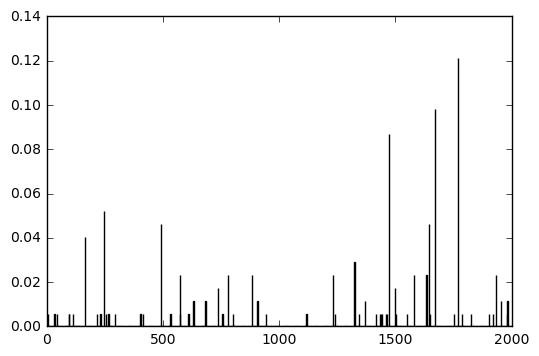

In [7]:
pyplot.bar(range(len(model1.feature_importances_)), model1.feature_importances_)
pyplot.show()

Now we are going to perform a heuristic experiment to check if the inference about the feature importance is valid or not. The problem statement is : what are the number of features required to ensure the 99% of original nature of data is captured. To do this we will take an arthematic progression of feature importance scores.

In [10]:
#range of 30 feature importance values
thres_range=np.arange(0.001,0.031,0.001)
print(thres_range)

[ 0.001  0.002  0.003  0.004  0.005  0.006  0.007  0.008  0.009  0.01
  0.011  0.012  0.013  0.014  0.015  0.016  0.017  0.018  0.019  0.02
  0.021  0.022  0.023  0.024  0.025  0.026  0.027  0.028  0.029  0.03 ]


In below code counts calculates the number of features that are above the given threshold. sums calculates the overall feature importance score for given threshold. The code is self explinatory

In [12]:
counts=[]
sums=[]
for thresh in thres_range:
    cur_count=0
    cur_sum=0
    for i in model1.feature_importances_:
        if i>=thresh:
            cur_sum+=i
            cur_count+=1
    counts.append(cur_count)
    sums.append(cur_sum)

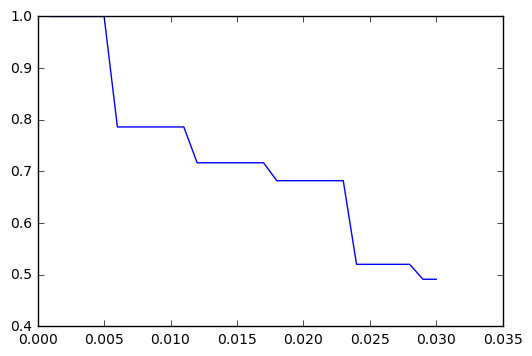

In [14]:
sums=np.array(sums)
pyplot.plot(thres_range, sums)
pyplot.show()

In [22]:
print(sums[3]) #0.03
print(sums[4]) #0.04
print(sums[5]) #0.05

0.999999977648
0.999999977648
0.786127150059


We can see from above graph at a threshold around 0.04, we can get 99% coverage of nature of data.
Below graph we will plot counts per threshold heuristic. From the below graph we can see that approx 60 features are more than enough to capture the  99% nature of data.

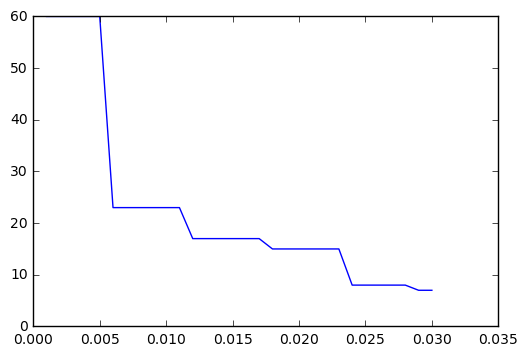

In [13]:
counts=np.array(counts)
pyplot.plot(thres_range, counts)
pyplot.show()

In [21]:
print(counts[3]) #0.03
print(counts[4]) #0.04
print(counts[5]) #0.05

60
60
23


From the experiments we can see that threshold can be fixed to 0.04 with number of features to 60.We will select the 60 features with highest values of feature importance and apply the classifiers like SVM,Random Forest.

Dimensionality reduction experiments :
Before going to classification we will test Dimensionality reduction using PCA. One intutive assumption is after the dimensionality reduction 99 or 98 percent of variability must be preserved in 60 or less features.

In [26]:
mean_vec = np.mean(X_std, axis=0)
cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
tot = sum(eig_vals)

#var_exp is similar to softmax or normalization as probability.
var_exp = [(i / tot) for i in eig_vals]
thres_range=np.arange(0.001,0.031,0.001)
print(thres_range)

[ 0.001  0.002  0.003  0.004  0.005  0.006  0.007  0.008  0.009  0.01
  0.011  0.012  0.013  0.014  0.015  0.016  0.017  0.018  0.019  0.02
  0.021  0.022  0.023  0.024  0.025  0.026  0.027  0.028  0.029  0.03 ]


In [31]:
print(sum(var_exp))  # summed up to one

(1+0j)


In [28]:
counts=[]
sums=[]
for thresh in thres_range:
    cur_count=0
    cur_sum=0
    for i in var_exp:
        if i>=thresh:
            cur_sum+=i
            cur_count+=1
    counts.append(cur_count)
    sums.append(cur_sum)

/usr/local/lib/python3.4/dist-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


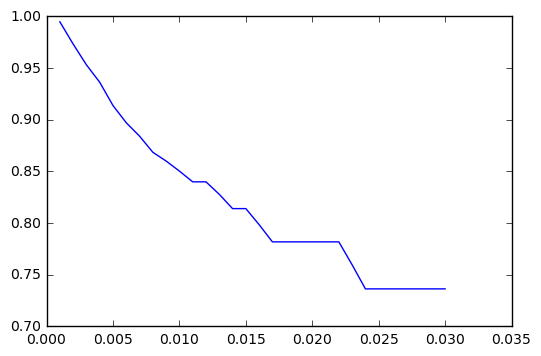

In [29]:
sums=np.array(sums)
pyplot.plot(thres_range, sums)
pyplot.show()

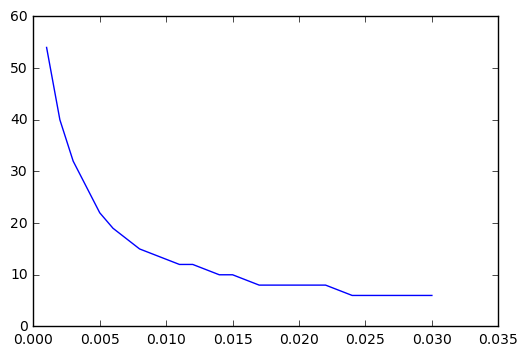

In [30]:
counts=np.array(counts)
pyplot.plot(thres_range, counts)
pyplot.show()

From above experiments we can see that 54 eigen valaue/vector pairs are enough to preserve 99% 
variability of the data. 

Also lets visualize the data using t-SNE so that we see the effectiveness of this manifold based method.
t-SNE was not able to capture the representation.

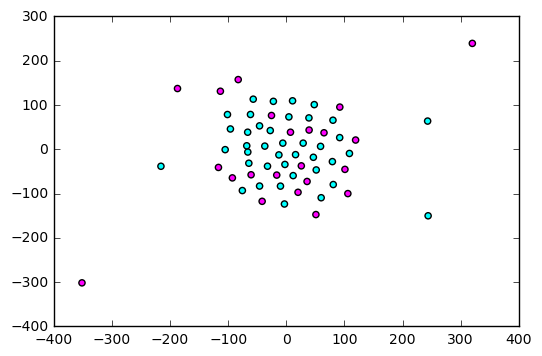

In [35]:
from sklearn.manifold import TSNE
import pylab
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
new_data=model.fit_transform(X_std)
pyplot.scatter(new_data[:,0], new_data[:,1],c=y,cmap=pylab.cm.cool)
pyplot.show()

BASELINE ESTIMATION :
    To evaluate our results its necessary to have a baseline measure before performing our classification experiments. Also as the dataset is imbalanced, recommended approach is to measure PER LABEL Precision,Recall and F1 score. 
    In the below experiment we are using a simple baseline classifier and measuring PER LABEL Precision,Recall,F1 score and confusion matrix.
    From our previous version experiments we can take our training data size to 40%,50%,60%. We will perform our experiments on these 3 sizes.

Below functions are for computing confusion_matrix, per lable precision,recall and F1 score.

In [12]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=pyplot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    pyplot.imshow(cm, interpolation='nearest', cmap=cmap)
    pyplot.title(title)
    pyplot.colorbar()
    tick_marks = np.arange(len(classes))
    pyplot.xticks(tick_marks, classes, rotation=45)
    pyplot.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pyplot.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    pyplot.tight_layout()
    pyplot.ylabel('True label')
    pyplot.xlabel('Predicted label')

def precision_recall_f1(y_labs,y_preds):
    if len(y_labs)==len(y_preds) :
        TruPos=float(0)
        FalNeg=float(0)
        TruNeg=float(0)
        FalPos=float(0)
        iter_len=range(0,len(y_labs))
        count=0
        for index in iter_len:
            if y_labs[index]==y_preds[index] :
                if y_labs[index]==1 : TruPos+=1
                else : TruNeg+=1
            else:
                if y_labs[index]==1 : FalNeg+=1
                else : FalPos+=1
        Pos_Prec=float(TruPos)/(float(TruPos)+float(FalPos))
        Neg_Prec=float(TruNeg)/(float(TruNeg)+float(FalNeg))
        Pos_Recall=float(TruPos)/(float(TruPos)+float(FalNeg))
        Neg_Recall=float(TruNeg)/(float(TruNeg)+float(FalPos))
        Pos_F1=2*((Pos_Prec*Pos_Recall)/(Pos_Prec+Pos_Recall))
        Neg_F1=2*((Neg_Prec*Neg_Recall)/(Neg_Prec+Neg_Recall))
        return Pos_Prec,Neg_Prec,Pos_Recall,Neg_Recall,Pos_F1,Neg_F1

Below Baseline experiments show the metrics for 40,50,60 percent of test sets. Code is self explanatory.

Confusion matrix, without normalization


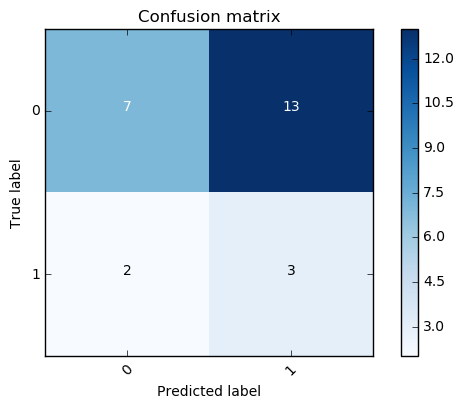

In [51]:
from sklearn.metrics import confusion_matrix
import itertools
#for 40% test data
ts=0.4
X_train, X_test, y_train, y_test = train_test_split(X_std, y, random_state=0,test_size=ts)
clf = DummyClassifier(random_state=0)
clf.fit(X_train, y_train)
DummyClassifier(constant=None, random_state=0, strategy='most_frequent')
y_pred=clf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred,labels=[0,1])
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix')
pyplot.show()

In [54]:
def printMetrics():
    print("================FOR "+str(100*ts)+" PERCENT TEST DATA================")
    Pos_Prec,Neg_Prec,Pos_Recall,Neg_Recall,Pos_F1,Neg_F1 =precision_recall_f1(y_test,y_pred)
    print("positive class precision is "+str(Pos_Prec))
    print("positive class recall is "+str(Pos_Recall))
    print("positive class F1 is "+str(Pos_F1))
    print("negative class precision is "+str(Neg_Prec))
    print("negative class recall is "+str(Neg_Recall))
    print("negative class F1 is "+str(Neg_F1))

printMetrics()

================FOR 50.0 PERCENT TEST DATA================
positive class precision is 0.15
positive class recall is 0.42857142857142855
positive class F1 is 0.2222222222222222
negative class precision is 0.6363636363636364
negative class recall is 0.2916666666666667
negative class F1 is 0.4


Confusion matrix, without normalization


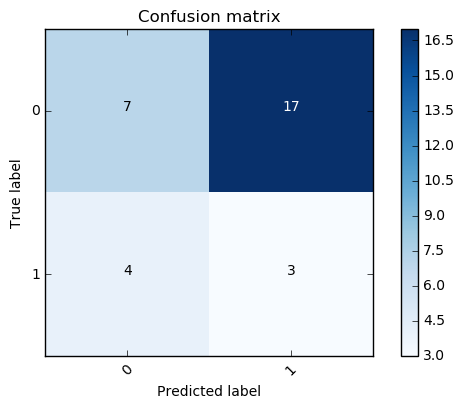

In [53]:
ts=0.5
X_train, X_test, y_train, y_test = train_test_split(X_std, y, random_state=0,test_size=ts)
clf = DummyClassifier(random_state=0)
clf.fit(X_train, y_train)
DummyClassifier(constant=None, random_state=0, strategy='most_frequent')
y_pred=clf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred,labels=[0,1])
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix')
pyplot.show()

In [55]:
printMetrics()

================FOR 50.0 PERCENT TEST DATA================
positive class precision is 0.15
positive class recall is 0.42857142857142855
positive class F1 is 0.2222222222222222
negative class precision is 0.6363636363636364
negative class recall is 0.2916666666666667
negative class F1 is 0.4


Confusion matrix, without normalization


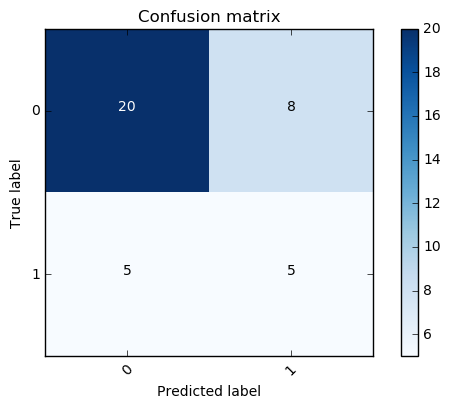

In [56]:
ts=0.6
X_train, X_test, y_train, y_test = train_test_split(X_std, y, random_state=0,test_size=ts)
clf = DummyClassifier(random_state=0)
clf.fit(X_train, y_train)
DummyClassifier(constant=None, random_state=0, strategy='most_frequent')
y_pred=clf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred,labels=[0,1])
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix')
pyplot.show()

In [57]:
printMetrics()

================FOR 60.0 PERCENT TEST DATA================
positive class precision is 0.38461538461538464
positive class recall is 0.5
positive class F1 is 0.4347826086956522
negative class precision is 0.8
negative class recall is 0.7142857142857143
negative class F1 is 0.7547169811320756


All the above metrics serves as the baseline measures for our following experiments.
Next we are going to use random forests and svms with polynomial and rbf kernels for classification

In the below cell we are going to perform classification using random forests with number of trees tuned from 1 to 20. We restrict number of dimension to 60 as we have seen from above experiments that 60 dimensions are more than enough to capture 99% of data variability. Lets define few more variables and functions for our experiment.

In [6]:
from sklearn.decomposition import PCA
pos=22
neg=40
nDims=60
pca = PCA(n_components=nDims)
#X_std is defined in above experiment is being used as it is
pca.fit(X_std)
X_pca=pca.transform(X_std)

pos_count_tr=0
neg_count_tr=0
tes_pos_co=0
tes_neg_co=0

In [7]:
#function prepareData splits the training and testing data from X_std with equal proportion of both the classes

def prepareData(testPercent,totalData):
    total_len=len(totalData[:,1])
    tes_pos_co=int(testPercent*pos)
    tes_neg_co=int(testPercent*neg)
    pos_count_tr=pos-tes_pos_co
    neg_count_tr=neg-tes_neg_co
    trainCount=pos_count_tr+neg_count_tr
    testCount=tes_neg_co+tes_pos_co
    trainX=np.zeros([trainCount,60])
    trainY=np.zeros([trainCount])
    testX=np.zeros([testCount,60])
    testY=np.zeros([testCount])
    trPsTemp=0
    trNgTemp=0
    tesPsTemp=0
    tesNgTemp=0
    for i in range(0,total_len):
        if y[i]==0:
            if trNgTemp<neg_count_tr:
                trainX[trNgTemp]=totalData[i,:]
                trainY[trNgTemp]=0
                trNgTemp+=1
            else:
                testX[tesNgTemp]=totalData[i,:]
                testY[tesNgTemp]=0
                tesNgTemp+=1
        else:
            if trPsTemp<pos_count_tr:
                trainX[trPsTemp]=totalData[i,:]
                trainY[trPsTemp]=1
                trPsTemp+=1
            else:
                testX[tesPsTemp]=totalData[i,:]
                testY[tesPsTemp]=1
                tesPsTemp+=1
    return trainX,trainY,testX,testY

Below code does classification using RandomForests and the output is a bit crude. We will have a nice tabular representation at the end of all experiments.
for the time being output format is :
"PositivClassPrecision,NegativClassPrecision,PositivClassRecall,NegativClassRecall,PositivClasF1,NegativClassF1"

In [22]:
from sklearn.ensemble import RandomForestClassifier
for testPercent in [0.4,0.5,0.6]:
    trainX,trainY,testX,testY=prepareData(testPercent,X_pca)
    for estimatior in range(1,21):
        forest = RandomForestClassifier(n_estimators = estimatior)
        forest = forest.fit(trainX,trainY)
        output = forest.predict(testX)
        print("================FOR "+str(100*testPercent)+" PERCENT TEST DATA AND ESTIMATOR "+str(estimatior)+"================")
        print(precision_recall_f1(testY,output))
    print("-------------------------------------end of the expt with given test percent-------------------------------------")
    print()

================FOR 40.0 PERCENT TEST DATA AND ESTIMATOR 1================
(0.5, 0.7, 0.25, 0.875, 0.3333333333333333, 0.7777777777777777)
================FOR 40.0 PERCENT TEST DATA AND ESTIMATOR 2================
(0.3333333333333333, 0.6666666666666666, 0.125, 0.875, 0.18181818181818182, 0.7567567567567567)
================FOR 40.0 PERCENT TEST DATA AND ESTIMATOR 3================
(0.6666666666666666, 0.8666666666666667, 0.75, 0.8125, 0.7058823529411765, 0.8387096774193549)
================FOR 40.0 PERCENT TEST DATA AND ESTIMATOR 4================
(0.5714285714285714, 0.7647058823529411, 0.5, 0.8125, 0.5333333333333333, 0.787878787878788)
================FOR 40.0 PERCENT TEST DATA AND ESTIMATOR 5================
(0.6, 0.8571428571428571, 0.75, 0.75, 0.6666666666666665, 0.7999999999999999)
================FOR 40.0 PERCENT TEST DATA AND ESTIMATOR 6================
(0.6666666666666666, 0.8666666666666667, 0.75, 0.8125, 0.7058823529411765, 0.8387096774193549)
================FOR 40.0 PERC

SVM Experiments:
We are going to use linear,Polynomila and RBF kernels and perform experiments by tuning parameters like C and gamma.Also we will use class weighting mechanisms.One of the traditional approaches to tune these parameters is to use grid search. But we will manually tune these parameters.
    The C parameter tells the SVM optimization how much we want to avoid misclassifying each training example. For large values of C, the optimization will choose a smaller-margin hyperplane if that hyperplane does a better job of getting all the training points classified correctly. Conversely, a very small value of C will cause the optimizer to look for a larger-margin separating hyperplane, even if that hyperplane misclassifies more points. For very tiny values of C, we should get misclassified examples, often even if our training data is linearly separable.
    

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import svm

from sklearn.decomposition import PCA
df = pd.read_csv(
    filepath_or_buffer='/home/kushwanth/Downloads/ColonTumor/colonTumor.data',
    header=None,
    sep=',')
# split data into X and y
X = df.ix[:,0:1999].values
X_std = StandardScaler().fit_transform(X)
y_labs = df.ix[:,2000].values
y=np.zeros(62,dtype=np.int)
i=0
for value in df.ix[:,2000].values:
    if value=='positive':
        y[i]=int(1)
    else: y[i]=int(0)
    i=i+1


pos=22
neg=40
nDims=60
pca = PCA(n_components=nDims)
pca.fit(X_std)
X_pca=pca.transform(X_std)

pos_count_tr=0
neg_count_tr=0
tes_pos_co=0
tes_neg_co=0
#testPercent must be between 0 to 1
#totalData is of shape 62:2000
#ie nsamples:ndimensions
def prepareData(testPercent,totalData):
    total_len=len(totalData[:,1])
    tes_pos_co=int(testPercent*pos)
    tes_neg_co=int(testPercent*neg)
    pos_count_tr=pos-tes_pos_co
    neg_count_tr=neg-tes_neg_co
    trainCount=pos_count_tr+neg_count_tr
    testCount=tes_neg_co+tes_pos_co
    trainX=np.zeros([trainCount,60])
    trainY=np.zeros([trainCount])
    testX=np.zeros([testCount,60])
    testY=np.zeros([testCount])
    trPsTemp=0
    trNgTemp=0
    tesPsTemp=0
    tesNgTemp=0
    for i in range(0,total_len):
        if y[i]==0:
            if trNgTemp<neg_count_tr:
                trainX[trNgTemp]=totalData[i,:]
                trainY[trNgTemp]=0
                trNgTemp+=1
            else:
                testX[tesNgTemp]=totalData[i,:]
                testY[tesNgTemp]=0
                tesNgTemp+=1
        else:
            if trPsTemp<pos_count_tr:
                trainX[trPsTemp]=totalData[i,:]
                trainY[trPsTemp]=1
                trPsTemp+=1
            else:
                testX[tesPsTemp]=totalData[i,:]
                testY[tesPsTemp]=1
                tesPsTemp+=1
    return trainX,trainY,testX,testY





def precision_recall_f1(y_labs,y_preds):
    if len(y_labs)==len(y_preds) :
        TruPos=float(0)
        FalNeg=float(0)
        TruNeg=float(0)
        FalPos=float(0)
        iter_len=range(0,len(y_labs))
        count=0
        for index in iter_len:
            if y_labs[index]==y_preds[index] :
                if y_labs[index]==1 : TruPos+=1
                else : TruNeg+=1
            else:
                if y_labs[index]==1 : FalNeg+=1
                else : FalPos+=1
        Pos_Prec=float(TruPos)/(float(TruPos)+float(FalPos))
        Neg_Prec=float(TruNeg)/(float(TruNeg)+float(FalNeg))
        Pos_Recall=float(TruPos)/(float(TruPos)+float(FalNeg))
        Neg_Recall=float(TruNeg)/(float(TruNeg)+float(FalPos))
        Pos_F1=2*((Pos_Prec*Pos_Recall)/(Pos_Prec+Pos_Recall))
        Neg_F1=2*((Neg_Prec*Neg_Recall)/(Neg_Prec+Neg_Recall))
        return Pos_Prec,Neg_Prec,Pos_Recall,Neg_Recall,Pos_F1,Neg_F1

from sklearn.model_selection import cross_val_score


rang_array=np.arange(-20,11,1)
trainX,trainY,testX,testY=prepareData(0.5,X_pca)
kernels=['linear', 'poly']
for kern in kernels:
    cs=[]
    for cpow in rang_array:
        c=pow(2,cpow)
        clf = svm.SVC(kernel=kern, C=c,class_weight={0:0.2,1:0.8})
        cur_scores=cross_val_score(clf, trainX,trainY,cv=5)
        cs.append([c,np.mean(cur_scores)])
    cs=sorted(cs, reverse=True,key=lambda cs: cs[1])
    print("for "+kern+" kernel "+str(cs[0]))



gamma_pow=np.arange(-20,5,1)
kern='rbf'
cs=[]
for gpow in gamma_pow:
    g=pow(2,gpow)
    for cpow in rang_array:
            c=pow(2,cpow)
            clf = svm.SVC(kernel=kern, C=c,gamma=g,class_weight={0:0.2,1:0.8})
            cur_scores=cross_val_score(clf, trainX,trainY,cv=5)
            cs.append([g,c,np.mean(cur_scores)])
cs=sorted(cs, reverse=True,key=lambda cs: cs[2])
print("for "+kern+" kernel "+str(cs[0]))


for linear kernel [0.00390625, 1.0]
for poly kernel [0.00048828125, 0.8761904761904763]
for rbf kernel [1.9073486328125e-06, 1024, 1.0]
